In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

data = pd.read_csv(r"[DS Intern] 1_N Model Performance Metrics - 2. Background Match Result.csv")

df = data.copy()

df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Case ID,Background\nMatch,Model A,Model B,NaN,NaN,NaN,NaN
2,NaN,2,YES,1.000,0.988,NaN,NaN,Model A,Model B
3,NaN,3,YES,1.000,0.985,NaN,FAR,?,?
4,NaN,4,YES,1.000,0.995,NaN,FRR,?,?


In [2]:
# drop kolom yang kamu tidak mau
df2 = df.drop(columns=["Unnamed: 0", "Unnamed: 5", "Unnamed: 6", "Unnamed: 7", "Unnamed: 8"])

# hapus baris pertama
df2 = df2.drop(index=0).reset_index(drop=True)

# reset index biar rapi
df2 = df2.reset_index(drop=True)

df2.head()

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Case ID,Background\nMatch,Model A,Model B
1,2,YES,1.000,0.988
2,3,YES,1.000,0.985
3,4,YES,1.000,0.995
4,5,YES,1.000,0.953


In [3]:
# set baris pertama sebagai header
df2.columns = df2.iloc[0]

# hapus baris pertama (karena sudah jadi header)
df2 = df2.drop(index=0).reset_index(drop=True)

df2.head()

,Case ID,Background\nMatch,Model A,Model B
0,2,YES,1.000,0.988
1,3,YES,1.000,0.985
2,4,YES,1.000,0.995
3,5,YES,1.000,0.953
4,6,YES,1.000,0.996


In [4]:
counts = df2['Background\nMatch'].value_counts()

print("Jumlah tiap label:")
print(counts)

df2.head()

Jumlah tiap label:
Background\nMatch
NO     1974
YES     459
Name: count, dtype: int64


,Case ID,Background\nMatch,Model A,Model B
0,2,YES,1.000,0.988
1,3,YES,1.000,0.985
2,4,YES,1.000,0.995
3,5,YES,1.000,0.953
4,6,YES,1.000,0.996


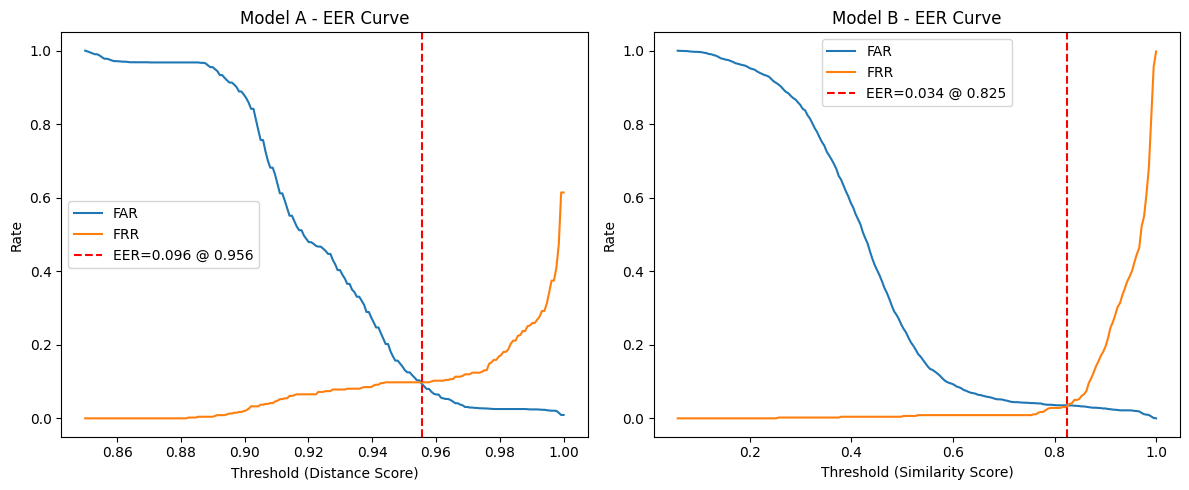

MODEL A:
  Threshold EER: 0.956
  FAR @ EER: 0.094
  FRR @ EER: 0.098
  EER: 0.096

MODEL B:
  Threshold EER: 0.825
  FAR @ EER: 0.035
  FRR @ EER: 0.033
  EER: 0.034


In [5]:
# Pastikan kolom numerik
df2['Model A'] = pd.to_numeric(df2['Model A'], errors='coerce')
df2['Model B'] = pd.to_numeric(df2['Model B'], errors='coerce')

# Label biner: MATCH=1, NOT MATCH=0
labels = df2['Background\nMatch'].map({'YES': 1, 'NO': 0}).values

def compute_far_frr(scores, labels, is_distance=True):
    """
    Hitung FAR & FRR untuk berbagai threshold
    - is_distance=True: threshold ke bawah (lebih kecil = MATCH)
    - is_distance=False: threshold ke atas (lebih besar = MATCH)
    """
    thresholds = np.linspace(min(scores), max(scores), 200)
    fars, frrs = [], []

    total_neg = np.sum(labels == 0)  # NOT MATCH
    total_pos = np.sum(labels == 1)  # MATCH

    for th in thresholds:
        if is_distance:
            preds = (scores >= th).astype(int)  # distance kecil = MATCH
        else:
            preds = (scores >= th).astype(int)  # similarity besar = MATCH

        fa = np.sum((preds == 1) & (labels == 0))  # False Accept
        fr = np.sum((preds == 0) & (labels == 1))  # False Reject

        fars.append(fa / total_neg if total_neg > 0 else 0)
        frrs.append(fr / total_pos if total_pos > 0 else 0)

    return thresholds, np.array(fars), np.array(frrs)

# =========================
# Model A (distance score)
thr_a, far_a, frr_a = compute_far_frr(df2['Model A'].values, labels, is_distance=True)
eer_idx_a = np.argmin(np.abs(far_a - frr_a))
eer_a = (far_a[eer_idx_a] + frr_a[eer_idx_a]) / 2
eer_thr_a = thr_a[eer_idx_a]

# Model B (similarity score)
thr_b, far_b, frr_b = compute_far_frr(df2['Model B'].values, labels, is_distance=False)
eer_idx_b = np.argmin(np.abs(far_b - frr_b))
eer_b = (far_b[eer_idx_b] + frr_b[eer_idx_b]) / 2
eer_thr_b = thr_b[eer_idx_b]

# =========================
# Plot EER curves
plt.figure(figsize=(12,5))

# Model A
plt.subplot(1,2,1)
plt.plot(thr_a, far_a, label='FAR')
plt.plot(thr_a, frr_a, label='FRR')
plt.axvline(eer_thr_a, color='red', linestyle='--', label=f'EER={eer_a:.3f} @ {eer_thr_a:.3f}')
plt.xlabel('Threshold (Distance Score)')
plt.ylabel('Rate')
plt.title('Model A - EER Curve')
plt.legend()

# Model B
plt.subplot(1,2,2)
plt.plot(thr_b, far_b, label='FAR')
plt.plot(thr_b, frr_b, label='FRR')
plt.axvline(eer_thr_b, color='red', linestyle='--', label=f'EER={eer_b:.3f} @ {eer_thr_b:.3f}')
plt.xlabel('Threshold (Similarity Score)')
plt.ylabel('Rate')
plt.title('Model B - EER Curve')
plt.legend()

plt.tight_layout()
plt.show()

# FAR & FRR di threshold EER
far_at_eer_a = far_a[eer_idx_a]
frr_at_eer_a = frr_a[eer_idx_a]

far_at_eer_b = far_b[eer_idx_b]
frr_at_eer_b = frr_b[eer_idx_b]

# =========================
# Print hasil
print("MODEL A:")
print(f"  Threshold EER: {eer_thr_a:.3f}")
print(f"  FAR @ EER: {far_at_eer_a:.3f}")
print(f"  FRR @ EER: {frr_at_eer_a:.3f}")
print(f"  EER: {eer_a:.3f}\n")

print("MODEL B:")
print(f"  Threshold EER: {eer_thr_b:.3f}")
print(f"  FAR @ EER: {far_at_eer_b:.3f}")
print(f"  FRR @ EER: {frr_at_eer_b:.3f}")
print(f"  EER: {eer_b:.3f}")



In [6]:
# Pastikan kolom numerik
df2['Model A'] = pd.to_numeric(df2['Model A'], errors='coerce')
df2['Model B'] = pd.to_numeric(df2['Model B'], errors='coerce')

# Label 0 = NOT MATCH, 1 = MATCH
labels = df2['Background\nMatch'].map({'NO':0, 'YES':1}).values
# Preprocessing
def preprocess_feature(feature_col):
    X = df2[[feature_col]].values
    scaler = StandardScaler()
    return scaler.fit_transform(X)

# Hitung EER
def calculate_eer(y_true, y_pred_prob):
    thresholds = np.linspace(0, 1, 1001)
    fars, frrs = [], []
    total_neg = np.sum(y_true == 0)
    total_pos = np.sum(y_true == 1)

    for th in thresholds:
        y_pred = (y_pred_prob >= th).astype(int)
        fa = np.sum((y_pred == 1) & (y_true == 0))
        fr = np.sum((y_pred == 0) & (y_true == 1))
        FAR = fa / total_neg if total_neg > 0 else 0
        FRR = fr / total_pos if total_pos > 0 else 0
        fars.append(FAR)
        frrs.append(FRR)

    fars, frrs = np.array(fars), np.array(frrs)
    idx_eer = np.argmin(np.abs(fars - frrs))
    eer = (fars[idx_eer] + frrs[idx_eer]) / 2
    return eer

# Training NN sederhana
def train_full_nn(feature_col, labels, fixed_threshold=None, is_distance=False):
    X_scaled = preprocess_feature(feature_col)
    y = labels

    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_scaled.shape[1],),
              kernel_regularizer=regularizers.l2(0.01)),
        Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_scaled, y, epochs=150, batch_size=16, verbose=0)

    # Prediksi probabilitas
    y_pred_prob = model.predict(X_scaled).flatten()

    # Prediksi biner pakai fixed threshold pada raw feature (bukan NN prob)
    if fixed_threshold is not None:
        if is_distance:
            y_pred = (df2[feature_col] >= fixed_threshold).astype(int).values
        else:
            y_pred = (df2[feature_col] >= fixed_threshold).astype(int).values
    else:
        y_pred = (y_pred_prob >= 0.5).astype(int)

    # Hitung FAR & FRR
    total_neg = np.sum(y == 0)
    total_pos = np.sum(y == 1)
    fa = np.sum((y_pred == 1) & (y == 0))
    fr = np.sum((y_pred == 0) & (y == 1))

    FAR = fa / total_neg if total_neg > 0 else 0
    FRR = fr / total_pos if total_pos > 0 else 0

    return FAR, FRR, fa, fr, total_neg, total_pos, y_pred_prob


# =========================
# Model A (distance score) dengan threshold tetap
FAR_a, FRR_a, fa_a, fr_a, total_neg_a, total_pos_a, y_pred_prob_a = train_full_nn(
    'Model A', labels, fixed_threshold=0.956, is_distance=True
)

# Model B (similarity score) dengan threshold tetap
FAR_b, FRR_b, fa_b, fr_b, total_neg_b, total_pos_b, y_pred_prob_b = train_full_nn(
    'Model B', labels, fixed_threshold=0.825, is_distance=False
)

# Hitung EER
eer_a = calculate_eer(labels, y_pred_prob_a)
eer_b = calculate_eer(labels, y_pred_prob_b)

# =========================
# Print hasil
print("MODEL A:")
print("  False Accepts:", fa_a)
print("  False Rejects:", fr_a)
print("  Total Negatives:", total_neg_a)
print("  Total Positives:", total_pos_a)
print("  FAR:", FAR_a)
print("  FRR:", FRR_a)
print("  EER:", eer_a)

print("\nMODEL B:")
print("  False Accepts:", fa_b)
print("  False Rejects:", fr_b)
print("  Total Negatives:", total_neg_b)
print("  Total Positives:", total_pos_b)
print("  FAR:", FAR_b)
print("  FRR:", FRR_b)
print("  EER:", eer_b)


c:\Users\itn.heydar.alvaro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\itn.heydar.alvaro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MODEL A:
  False Accepts: 186
  False Rejects: 45
  Total Negatives: 1974
  Total Positives: 459
  FAR: 0.09422492401215805
  FRR: 0.09803921568627451
  EER: 0.09613206984921628

MODEL B:
  False Accepts: 70
  False Rejects: 15
  Total Negatives: 1974
  Total Positives: 459
  FAR: 0.03546099290780142
  FRR: 0.032679738562091505
  EER: 0.03407036573494646
